# Variational Quantum Classifier - Fundamentals

_____________

In this notebook, I implement a **Variational Quantum Classifier (VQC)**, trained on the [iris dataset.](https://archive.ics.uci.edu/ml/datasets/iris) We will implement the model from scratch, using only basic tools from Qiskit, with the goal of actually understanding how the model works, and what it's doing.

A VQC is also called a **Parameterized Quantum Circuit**, which refers to the way these models work: they are quantum circuits whose gates (most often, rotations) are parameterized by free parameters in the parameter vector $\vec{\theta}$. These parameters are determined via the minimization of a loss function, calculated on data - that is, the parameters are *learned through data*. Hence, this is an example of a **quantum machine learning** algorithm. However, the optimization of the loss function is carried out classically, which is why we often refer to VQCs as **hybrid (classical-quantum) machine learning models**.

Schematically, a VQC circuit can be summarized in 3 components, or layers:

- **Feature map $\mathcal{U}_{\Phi(\vec{x})}$**: part of the circuit responsible for encoding classical data $\vec{x}$ into quantum states which will be processed in the quantum circuit by the quantum algorithm;
- **Variational layer $W(\vec{\theta})$**: part of the circuit parameterized by $\vec{\theta}$. These are the parameters learned in the training process.
- **Measurement**: final part of the circuit, consisting of measurements of the quantum register(s), thus producing classical information.

<img src="https://www.researchgate.net/profile/Claudio-Gambella-2/publication/342464434/figure/fig4/AS:906517855358979@1593142107809/Quantum-circuit-for-Variational-Quantum-Classifier-VQC-that-consists-of-fixed-quantum.jpg" width=50%>

In the picture above, the feature map and variational layers were schematically represented by boxes (or algebraically by $\mathcal{U}_{\Phi(\vec{x})}$, $W(\vec{\theta})$, but, naturally, they represent unitary operations which can be constructed in several different ways (that is, different ansätze). The choice of particular constructions is often refered to as the **architecture** of the VQC.

As aforementioned, VQC is a hybrid algorithm, because it uses classical routines to optimize the parameters $\vec{\theta}$ according to the training data. This process is illustrated below, via the construction of a classical loss/cost function, directly from the measurements of the quantum registers in the last layers of the circuit (which produces classical data):

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-50433-5_45/MediaObjects/500809_1_En_45_Fig1_HTML.png" width=50%>

VQC is often also refered to as a **Quantum Neural Network**, because of the resemblance between some aspects of its structure and training procedure with respect to that of classical neural networks (NN), which are also layered models whose parameters are determined via the minimization of a loss function evaluated on data:

<img src="https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Backpropagation.gif" width=50%>

If we draw this analogy, one could say that VQC is a neural network whose forward propagation is quantum (performed by a quantum circuit), whilst its backpropagation (actual optimization step for the minimization of the loss) is performed classically. In context, this analogy is enough for one to call VQC a "quantum neural network". But, personally, I think this denomination (implying this analogy) may cause some confusion, for the following reason: one major ingredient of classical neural networks (in great part responsible for its outstanding performance) is the non-linearity introduced by actiavtion functions on the units:

<img src="https://miro.medium.com/max/512/1*sPg-0hha7o3iNPjY4n-vow.jpeg" width=50%> 

<img src="https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png" width=50%>

Now, all gates performed in a quantum circuit are **linear, unitary operators**. Although there are some proposals of implementing non-liniearities in quantum circuits (see, for example [this paper](https://arxiv.org/abs/1806.06871), or [this one](https://arxiv.org/abs/1808.10047) which deals with photonic quantum computing), which would indeed reproduce all major ingredients of a classical neural network (included non-linear activation functions) to be implemented in a quantum computer, this is not a trivial task to be implemented on general architectures. And this is not what we will implement in this notebook. Thus, I prefer to avoid the "quantum neural network" denomination, as I think it can be a bit misleading, specitally if taken out of context.

______________________

In this notebook, we will build a simple variational quantum classifier, to illustrate the procedure and its main ideas. We will use the iris dataset, but reduced to a binary classification of species setosa and versicolor only. Each feature will be encoded in one qubit (therefore, our circuit will consist of 4 qubits). 

This implementation serves well the goal of understanding what the model is actually doing. But, given its simplicity, its performance probably won't be that great, and that's indeed not the primary goal here. Fot better performing models, I suggest [Qiskit's](https://qiskit.org/documentation/tutorials/machine_learning/03_vqc.html) or [PennyLane's](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) implementation of variational quantum classifiers. In these implementations, you find not only more flexibility on the model architecture, but also different (and potentially better) ways to perform the optimization (learning) procedure.

Let's begin!

_____________

**Import data analysis/visualization libraries**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

**Reading the data**

In [2]:
df = pd.read_csv("iris.csv")

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


**Preprocess**

In [4]:
# map between integer label and categorical target

cat_map = dict(zip(df["species"].astype("category").cat.codes, df["species"]))
print("\nTarget integer-label encoding:", cat_map, "\n\n")

# categorical target --> integer label

df["species"] = df["species"].astype("category").cat.codes

#################################################################################

# taking only species 1 and 0 -- binary classification

df = df[df["species"].isin([0, 1])]

#################################################################################

df.info()


Target integer-label encoding: {0: 'setosa', 1: 'versicolor', 2: 'virginica'} 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  100 non-null    float64
 1   sepal_width   100 non-null    float64
 2   petal_length  100 non-null    float64
 3   petal_width   100 non-null    float64
 4   species       100 non-null    int8   
dtypes: float64(4), int8(1)
memory usage: 4.0 KB


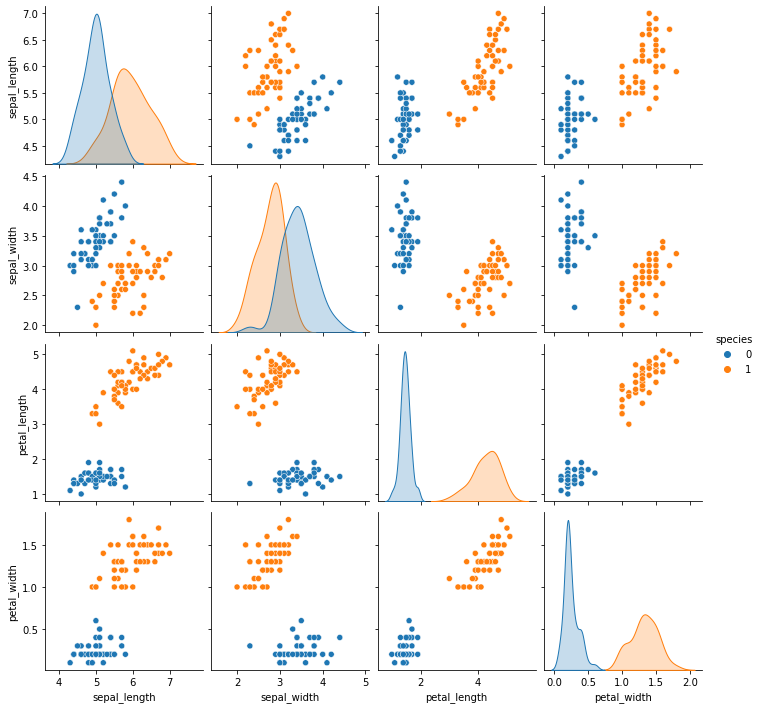

In [5]:
sns.pairplot(df, hue="species")

In [6]:
# features
X = df.drop(columns="species")

# target
y = df["species"]

In [7]:
# train-test split, 20% test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

___________


**Classical classifier benchmark: logistic regression**

In [8]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=42).fit(X, y)

y_pred = logit.predict(X_test)

#################################################################################

from sklearn.metrics import classification_report, confusion_matrix

print("Claffical classifier (Logistic Regression):\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Claffical classifier (Logistic Regression):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

[[10  0]
 [ 0 10]]


As expected, the very simple classical classifier Logistic Regression worked very well, given the linear separability of our data. Let's now see how our quantum classifier works!

___________


**Variational Quantum Classifier**

Let's now start building the VQC!

To begin with, let's import the relevant functions of qiskit:

In [9]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

Defining the number of qubits in the quantum circuit:

In [10]:
# we'll encode each feature in a single qubit. Thus, that's the number of qubits

N = X.shape[1]

**Initial state**

We initialize the computation with the initial state

$$ \left | \psi_0 \right > = \left | 0 \right > ^{\otimes N} $$ 

where in the iris dataset case, $N=4$.


Initial Circuit:



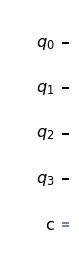

In [11]:
# let's start with N quantum register and 1 single classical register (for measurement readout)

qr = QuantumRegister(N, "q")
cr = ClassicalRegister(1, "c")

qc = QuantumCircuit(qr, cr)

print("\nInitial Circuit:\n")

qc.draw("mpl")

______

### Feature map

Encode classical data as rotation angles!

We will encode **one single observation in the circuit**. So, the qubits will be rotated by an anlge proportional to the respective feature of a single row (observation) per time.

The state is:

$$ \left | \psi_{1, k} \right >  = \prod_{i=0}^{N-1} R_x(\phi_{i, k}, i) \left | \psi_0 \right >  \ , $$

where $\phi_{i, k} = X_{i, k}$ represents the value of the $i$-th feature ($i = 0, 1, \cdots, N-1$, in the iris dataset case, $N=4$) of the $k$-ith training observation (in the iris dataset case, with 20% test size, $k=80$). This precise value is used as the $R_x$ rotation angle. Naturally, each rotation $R_x$ acts in the respective $i$-th register (second argument).

Remember, the $R_x$ is

$$ \begin{align}\begin{aligned}\newcommand{\th}{\frac{\phi}{2}}\\\begin{split}R_x(\theta) = \text{e}^{-i \th X} =
    \begin{pmatrix}
        \cos{\th}   & -i\sin{\th} \\
        -i\sin{\th} & \cos{\th}
    \end{pmatrix}\end{split}\end{aligned}\end{align}$$
 

In [12]:
# selecting one single observation

k = 0
obs_k = X_train.iloc[k]

In [13]:
obs_k

sepal_length    5.7
sepal_width     4.4
petal_length    1.5
petal_width     0.4
Name: 15, dtype: float64

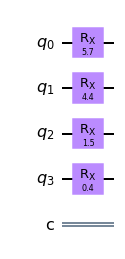

In [14]:
for i, phi_ik in enumerate(obs_k):
    
    qc.rx(phi_ik, i)
    
qc.draw("mpl")

________

### Variational Layer

Let's now build the parameterized (variational) layer of the circuit!

This part of the circuit will be made of parameterized rotations, whose parameters will be learned through the mimization of a cost function (which will be introduced later on), using the data. The parameters of the rotation will be collectively represented via the **variational paramets vector $\vec{\theta}$**, whose dimension depends on the chosen number of parameters. In the first example, we stick to 4 variational parameters, thus, $\vec{\theta}$ is 4-dimensional.

As it's the case with classical neural networks, the particular topology (architecture) of the variational circuit will influence the final model, and one should iterate different architectures to tune the model. In the second notebook in this repository, we try different architectures. In this first version, let's build the most natural architecutre: CNOTs between the registers to induce entanglement, followed by a final CNOT between the first and last register (with the first qubit as target), then followed by parameterized rotations (around the y-axis, to introduce rotations in a diferent axis from the feature map):

$$ \left | \psi_{2, k} \right > = U_{\text{var}} ( \vec{\theta} ) \left | \psi_{1, k} \right >  \ , $$

where the variational portion of the circuit is represented by the unitary $U_{\text{var}}(\vec{\theta})$, which is given by

$$ U_{\text{var}}(\vec{\theta}) =  \prod_{i=0}^{N-1} R_y(\theta_i, i) C_{\text{NOT}}(N-1, 0) \prod_{i=0}^{N-2} C_{\text{NOT}}(i, i+1)$$

Let's implement the code:

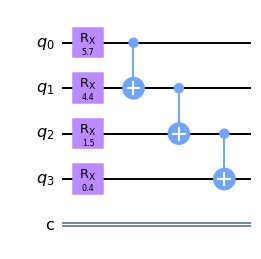

In [15]:
# CNOTs to induce entanglement

for i in range(N-1):
    
    qc.cnot(i, i+1)
    
qc.draw("mpl")

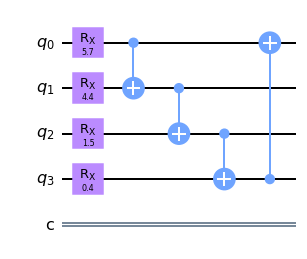

In [16]:
# CNOT, targeted on the first register

qc.cnot(N-1, 0)

qc.draw("mpl")

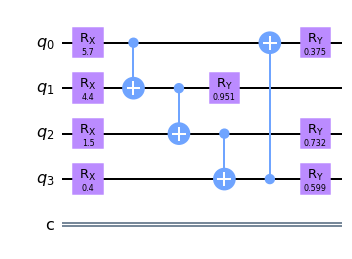

In [17]:
# parameterized rotations

# first, let's introduce a vector of (random) parameters. 
# that's the parameter vector \vec{\theta}

np.random.seed(42)
theta = np.random.uniform(0, 1, N)

for i in range(N):
    
    qc.ry(theta[i], i)
    
qc.draw("mpl")

________

### Measurement

Now, the first quantum register is measured. 

As the targets are binary (and encoded as 0/1), this measurement will be the circuit prediction!

The variational circuit above, apart from the respective parameterized rotations in each qubit, also introduced entanglement (top-down and bottom-up). With this, *loosely speaking*, all the registers are entangled, and information is carried out back to the first register.

Therefore, *the measurement of the first register will be the circuit prediction for the given obervartion (whose features were encoded in the qubits via the rotations in the feature map), after it passed through the parameterized rotations (which shall be trained on data)*


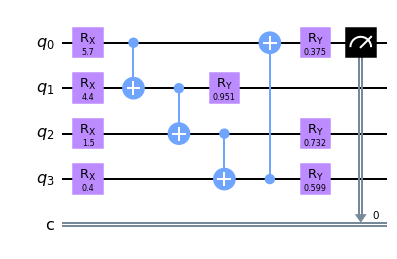

In [18]:
# measure the first qubit and put its readout in the classical register

qc.measure(0, cr)

qc.draw("mpl")

_______

### Run the full circuit

Now, we must run the circuit to see its output!

Remember, this is just like a NN whose weights were randomly initialized prior to the training: we do not expect it to get the right result as it is right now. The goal will be to **train** the rotations parameters with data, so that the trained circuit will yield good predictions for the target. We will get to this soon.

But first, let's see the results. We will run the circuit in a [simulator](https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html) from Aer (qasm, simulator of an actual quantum device: it yields the values in the classical register)

In [19]:
# import provider for simulator and define the simulator backend

from qiskit import Aer

backend = Aer.get_backend("qasm_simulator")

In [20]:
# defining the job and sending it to execute in the defined backend
# we will run the circuit a n_runs number of times
# we fix the simulator seed for reproducibility

n_runs = 1e3

from qiskit import execute

job = execute(qc, backend, shots=n_runs, seed_simulator=42)

In [21]:
# getting the results of the job execution

results = job.result()

results

Result(backend_name='qasm_simulator', backend_version='0.7.5', qobj_id='8632bf70-f135-46f3-bab6-6dd4dbdfd16c', job_id='3f86aa66-d7b2-4b8c-b924-09af24b34ff7', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=MeasLevel.CLASSIFIED, data=ExperimentResultData(counts={'0x0': 510, '0x1': 490}), header=QobjExperimentHeader(clbit_labels=[['c', 0]], creg_sizes=[['c', 1]], global_phase=0.0, memory_slots=1, n_qubits=4, name='circuit7', qreg_sizes=[['q', 4]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3]]), status=DONE, seed_simulator=42, time_taken=0.003393797, metadata={'fusion': {'applied': False, 'enabled': True, 'method': 'unitary', 'threshold': 14}, 'measure_sampling': True, 'method': 'statevector', 'parallel_shots': 1, 'parallel_state_update': 4})], date=2021-05-17T12:17:45.308326, status=COMPLETED, status=QobjHeader(backend_name='qasm_simulator', backend_version='0.7.5'), metadata={'max_memory_mb': 1919, 'omp_enabled': True, 'parallel_experiments': 1, 'tim

In [22]:
# To get the resulting counts (of measurements in the classical register),
# we use the get_counts() method

counts = results.get_counts()

counts

{'0': 510, '1': 490}

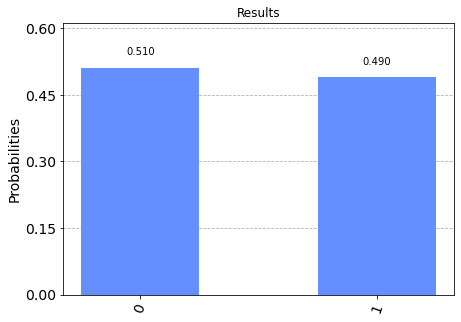

In [23]:
# ploting the counts above as a histogram

from qiskit.visualization import plot_histogram

plot_histogram(counts, title="Results")

It's useful (just like the logit), to interpret the results of the VQC as predictions of the probability $P(y_k=1 | x_k)$, that is, as the probability that the observation belongs to class 1:

In [24]:
p_y_k = counts["1"]/n_runs

p_y_k

0.49

We then can make the prediction, using a 50% threshold:

In [25]:
y_pred_k = 1 if p_y_k > 0.5 else 0

y_pred_k

0

Comparing with the actual label:

In [26]:
y_train.iloc[k]

0

The model got the label right, but it was almost a 50/50 tie...

Let's see if it was a difficult choice, comparing with the classical model:

In [27]:
logit.predict_proba(X_train.iloc[k].values.reshape(1, -1))

array([[0.9858607, 0.0141393]])

Not really! It should undoubtly be predicted to be 0!

Of course, though, this was expected, since the paremeters of the variational circuit where randomly initialized! To get actual data-driven predictions, we must train our VQC using the training data. That's what we will do below!

But before we get to the training of the VQC, it will be very useful to condense everything we did above in functions. When we get to the training, it will be clear why this will be important. So, let's do it:

In [28]:
# functions for the circuit construction

def initialize_circuit(Nq, Nc):
    '''
    initializes a circuit with Nq quantum registers and Nc classical registers
    '''
    
    # quantum and classical registers
    qr = QuantumRegister(Nq, "q")
    cr = ClassicalRegister(Nc, "c")

    # quantum circuit
    qc = QuantumCircuit(qr, cr)

    return qc

#########################################################################################
#########################################################################################

def feature_map(qc, X_k):
    '''
    encodes classical data (in the array X) into the quantum circuit initial state.
    each component of the X array is encoded in the respective quantum register.
    the encoding is achieved via a Rx rotation, whose angle is the respective X component
    '''
    
    # data encoding with Rx rotations
    for i, phi_ik in enumerate(X_k):
    
        qc.rx(phi_ik, i)
        
    return qc

#########################################################################################
#########################################################################################

def variational_circuit(qc, theta):
    '''
    implements the variational portion of the quantum cirrcuit.
    the particular architecture will be: CNOTs between the registers;
    followed by parameterized Ry rotations (parameters defined by the argument "theta"); 
    '''
    
    # CNOTs to induce entanglement
    for i in range(N-1):
    
        qc.cnot(i, i+1)
        
    # final CNOT, targeted on the first register
    qc.cnot(N-1, 0)

    # parameterized rotations
    for i in range(N):

        qc.ry(theta[i], i)
        
    return qc
        
#########################################################################################
#########################################################################################


def measurement(qc):
    '''
    measure the first quantum register into the classical register
    '''
    
    qc.measure(0, -1)
    
    return qc

In [29]:
# full function to construct the circuit

def build_circuit(Nq, Nc, X, theta, k, show_circuit=True):
    '''
    construct and return the quantum circuit for the variational quantum classifier
    '''

    qc = initialize_circuit(Nq, Nc)
    
    feature_map(qc, X.iloc[k])
    
    variational_circuit(qc, theta)
    
    measurement(qc)
    
    if show_circuit:
        
        show_figure(qc.draw("mpl"))
        
    return qc

In [30]:
# functions for the circuit execution

def run_circuit(qc, simulator=True, backend_name = "qasm_simulator", n_runs=1e3, seed_simulator=None):
    '''
    executes the quantum circuit in the specified backend (in the moment, it's just a simulator)
    TODO: allow for actual hardware
    the number of executions can also be specified.
    returns the results of the execution.
    '''
    
    if simulator:
        
        # import provider for simulator and define the simulator backend
        backend = Aer.get_backend(backend_name)
        
    else:
        
        pass
        # # todo: quantum hardware
        # backend = ...
        
    # defining the job and sending it to execute in the defined backend
    # we will run the circuit a n_runs number of times
    job = execute(qc, backend, shots=n_runs, seed_simulator=seed_simulator)
    
    # getting the results of the job execution
    results = job.result()
    
    return results

#########################################################################################
#########################################################################################

def show_figure(fig):
    '''
    auxiliar function to display plot 
    even if it's not the last command of the cell
    from: https://github.com/Qiskit/qiskit-terra/issues/1682
    '''
    
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

#########################################################################################
#########################################################################################

def final_answer(results, thresh=0.5, n_runs=1e3, visualize_results=False):
    '''
    calculate the probability of the observation belonging to class 1
    i.e., like the logit, calculation of P(y=1|x). 
    the actual class prediction is also calculated. both are returned.
    an optional visualization of the execution results as a histogram is also available
    '''

    # getting the resulting counts (of measurements in the classical register),
    counts = results.get_counts()
    
    if visualize_results:
        # ploting the counts as a histogram
        show_figure(plot_histogram(counts, title="Results"))
        
    # p(y=1 | x) - probability of observation belonging to class 1
    p_y = counts["1"]/n_runs
    
    # actual prediction, according to the specified threshold
    y_pred = 1 if p_y > thresh else 0
    
    return p_y, y_pred

In [31]:
# full vqc function (takes the quantum circuit as input and executes it)

def vqc(qc, simulator=True, backend_name = "qasm_simulator", n_runs=1e3,
        thresh=0.5, visualize_results=False, seed_simulator=None):
    '''
    this function integrates all the functions above in a single structure
    and returns p_y
    the only input is the integer k, used as an index for the chosen observation
    returns the final answer (probability and prediction)
    '''
    
    results = run_circuit(qc, seed_simulator=seed_simulator)

    return final_answer(results, visualize_results=visualize_results)

Running the full VQC:

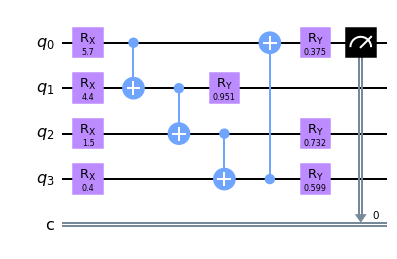

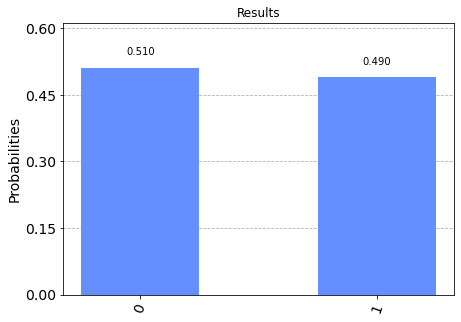

Predicted p(y=1|x) for the 0-th training observation: 0.49
Therefore, this observation is classified as 0


In [32]:
np.random.seed(42)
theta = np.random.uniform(0, 1, N)

qc = build_circuit(N, 1, X_train, theta, k=0, show_circuit=True)

p_y_k, y_pred_k = vqc(qc, seed_simulator=42, visualize_results=True)

print("Predicted p(y=1|x) for the " + str(k) + "-th training observation:", p_y_k)
print("Therefore, this observation is classified as", y_pred_k)

Now let's proceed to the training!

______

### Training the VQC

First, we must define our loss function. In this first example, let's go simple and use the squared error $L_k (\hat{y}, y) = (\hat{P}(y_k) - P(y_k))^2 = (\hat{P}(y_k)- y_k)^2$ as our loss, where $P(y_k) \equiv P(y_k | x_k)$.  Considering different losses will also be part of a next step of improvements!

In [33]:
def loss_SE(p_y_k, y, k):
    '''
    computes the squared error (SE) loss
    '''
    
    return (p_y_k - y.iloc[k])**2

In [34]:
loss_SE(p_y_k, y_train, k)

0.24009999999999998

Now, we must minimize the loss function $L_k(\hat{y}, y)$ with respect to the variational parameters vector $\vec{\theta}$.

In the context of neural networks, this optimization is often achieved with the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm, which consists of the **update** of the vartiational parameter vector according to:

$$ \vec{\theta} \mapsto \vec{\theta}  - \eta \partial_{\vec{\theta}}L_k \ , $$

where $\eta$ is the [learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/), and $\partial_{\vec{\theta}} \equiv \partial/\partial{\vec{\theta}}$ denotes the directional derivative with respective to the variational parameters vector $\vec{\theta}$.

More specifically, in this implementation we shall perform [stochastic gradient descent](https://youtu.be/vMh0zPT0tLI) for the loss optimization, which is characterized by the fact that the weight update step outlined above is performed for every observation of the training dataset.

Now, since $\hat{P}(y_k) = \hat{P}(y_k(\vec{\theta}))$ indirectly depends on $\vec{\theta}$, we could in principle analitically calculate the derivatives and then update the variational parameters. But the thing is that the explicit functional dependence of $\hat{P}(y_k)$ in $\vec{\theta}$ could be quite complicated, as it depends on the actual quantum circuit.

However, as discussed [in this page of PennyLane](https://pennylane.ai/qml/glossary/parameter_shift.html), there is in fact a very natural way to compute analytic gradients of functions of quantum gates, with the so-called "parameter-shift rules", as introduced in [this paper](https://arxiv.org/abs/1803.00745) and extended in [this paper](https://arxiv.org/abs/1811.11184). PennyLane implements these rules natively, which then allows quantum nodes to be added to classical computational graphs, opening a whole new world of hybrid algorithms. I will discuss PennyLane and its great methods in future repositories.

In this implementation, we employ another method to compute the derivatives: via the (numeric) [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method), in which we approximate the derivative with a finite (but small) difference. That is, we will approximate:

$$ \frac{\partial L_k}{\partial_{\theta_i}} \approx \frac{L_k(\hat{y}(\theta_i + \delta), y) - L_k(\hat{y}(\theta_i), y)}{\delta} \ , $$

where $\theta_i$ denotes the $i$-th component of $\vec{\theta}$, and $\delta$ is a small deviation. Naturally, as long as $\delta$ is finite, this difference will only be an approximation to the actual derivative, which is achieved with $\delta \rightarrow 0$. If we choose a small enough $\delta$, we in general achieve a good approximation, although some care is needed in order to avoid numerical blowups. For some notes on the accuracy of the method, see [this link](https://en.wikipedia.org/wiki/Finite_difference_coefficient). 

Let's build the functions for the gradient decent:

In [35]:
def gradient(N, X, y, k, p_y_k, theta, delta=5e-3, seed_simulator=None):   
    '''
    computes the directional derivative using the finite difference method
    '''
    
    theta_list = []
    for i in range(len(theta)):

        theta_list.append(theta.copy())
        theta_list[-1][i] = theta_list[-1][i] + delta
    
    del_theta = []
    
    for theta_pd in theta_list:
        
        # below, pd = "plus delta"
        
        qc_pd = build_circuit(N, 1, X, theta_pd, k, show_circuit=False)
        p_y_k_pd, _ = vqc(qc_pd, seed_simulator=seed_simulator)

        loss_theta = loss_SE(p_y_k, y, k)
        loss_theta_pd = loss_SE(p_y_k_pd, y, k)

        derivative = (loss_theta_pd - loss_theta)/delta

        del_theta.append(derivative)
        
    return np.array(del_theta)

#########################################################################################
#########################################################################################

def train_accuracy(y_pred_k, y, k):
    
    return 1 if y_pred_k == y.iloc[k] else 0

#########################################################################################
#########################################################################################
    
def stochastic_gd(N, X, y, theta, lr = 5e-2, num_epochs=50, show_progress=True, seed_simulator=None):
    
    loss_each_epoch = []
    accuracy_each_epoch = []
    
    if show_progress:
        print("Epoch \t Loss \t Training Accuracy")
    
    for n in range(num_epochs):
        
        loss_inter_epoch = []
        accuracy_inter_epoch = []
        
        for k in range(X.shape[0]):
        
            qc = build_circuit(N, 1, X, theta, k, show_circuit=False)

            p_y_k, y_pred_k = vqc(qc, seed_simulator=seed_simulator)
            
            loss_inter_epoch.append(loss_SE(p_y_k, y, k))
            
            accuracy_inter_epoch.append(train_accuracy(y_pred_k, y, k))
            
            theta = theta - lr * gradient(N, X, y, k, p_y_k, theta, seed_simulator=seed_simulator)
    
        loss_each_epoch.append(np.mean(loss_inter_epoch)) 
        accuracy_each_epoch.append(np.mean(accuracy_inter_epoch)) 
        
        if show_progress:
            print(n+1, "\t", round(loss_each_epoch[-1], 3), "\t", round(accuracy_each_epoch[-1], 3))
            
    return loss_each_epoch, accuracy_each_epoch, theta

Now, let's run the full model training:

In [36]:
N = X_train.shape[1]

np.random.seed(42)

theta = np.random.uniform(0, 2*np.pi, N)

# making a copy for later comparison
theta_0 = theta.copy()

num_epochs = 20

training_loss, training_accuracy, theta_final = stochastic_gd(N, X_train, y_train, theta,
                                                              lr = 0.01, num_epochs=num_epochs, 
                                                              seed_simulator=42)

Epoch 	 Loss 	 Training Accuracy
1 	 0.215 	 0.775
2 	 0.215 	 0.788
3 	 0.214 	 0.762
4 	 0.211 	 0.788
5 	 0.21 	 0.8
6 	 0.21 	 0.788
7 	 0.208 	 0.775
8 	 0.205 	 0.8
9 	 0.204 	 0.762
10 	 0.203 	 0.838
11 	 0.202 	 0.825
12 	 0.201 	 0.838
13 	 0.201 	 0.825
14 	 0.201 	 0.85
15 	 0.2 	 0.825
16 	 0.201 	 0.825
17 	 0.199 	 0.862
18 	 0.199 	 0.85
19 	 0.198 	 0.862
20 	 0.197 	 0.875


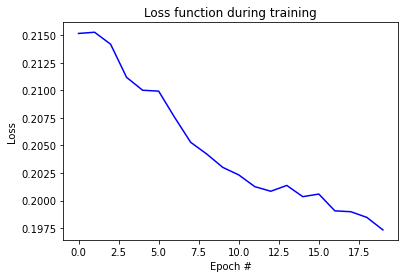

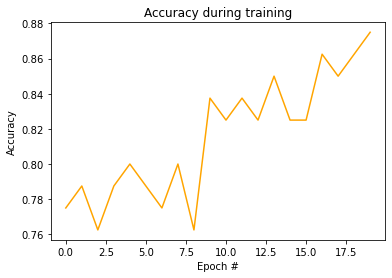

In [37]:
plt.title("Loss function during training")

sns.lineplot(x = range((len(training_loss))), y=training_loss, color="blue")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

plt.title("Accuracy during training")

sns.lineplot(x = range((len(training_accuracy))), y=training_accuracy, color="orange")

plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.show()

Let's take a look in the final trained variational parameters:

In [38]:
print("Final variational parameters vector:", theta_final)

print("\nMean training accuracy in the", num_epochs, "epochs:", np.mean(training_accuracy))

Final variational parameters vector: [2.88453497 5.94230016 4.72625958 3.87948019]

Mean training accuracy in the 20 epochs: 0.815625


_________

Let's now evaluate the VQC on the test set:

In [39]:
y_pred = []

for k in range(X_test.shape[0]):
    
    qc = build_circuit(N, 1, X_test, theta_final, k, show_circuit=False)

    _, y_pred_k = vqc(qc, seed_simulator=42)
                      
    y_pred.append(y_pred_k)

In [40]:
print("Quantum classifier (VQC):\n")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Quantum classifier (VQC):

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

[[ 8  2]
 [ 0 10]]


That's it!

In this notebook, we implemented a VQC from scratch, to better understand its inner workings.

The model achieved good performance, but considering that the iris dataset is linearly separable, a 100% performance would be expected. Why the quantum classifier wasn't able to capture this linear separability certainly is a very interesting question, worthy further research. 

Some directions of improvements could be, for instance: testing different architecutres of both the feature map and variational layer of the quantum circuit, or even in the choice of more suitable loss functions.

This is done in [this notebook](./vqc_iris_experiments.ipynb), in which different configurations are tested. All the components of the VQC model (including the aforementioned improvements) will be integrated in a [separate .py file](./vqc.py), which will be imported as a library, thus allowing for easier experimentation!

With this, we hope to find better results, or hints that the limitations may be in other components of the algorithm (the optimization step, for instance).
________